Aggregate patch-level pretrained CNN features into one slide-level vector (simple pooling) and check if slides show meaningful structure by PAM50 label (PCA/UMAP).
No training, no MIL model yet — just a defensible baseline.

Setup and input tables
Purpose

Load the mapped subset table (40 slides), confirm paths exist, and define constants for patch sampling + feature extraction.

In [1]:
import os
from pathlib import Path
import pandas as pd

# Ensure repo root (same as Notebook A)
REPO_ROOT = Path(r"D:\Projects\histo-to-omics-framework")
os.chdir(REPO_ROOT)
print("CWD:", os.getcwd())

wsi_dir = Path("data/raw/gdc/brca_phase1/wsi_subset")
labels_csv = Path("outputs/brca_subtyping/tables/brca_wsi_subset_selection.csv")

df = pd.read_csv(labels_csv)
print("Subset label table:", df.shape)

# Map filenames -> actual SVS path
svs_files = [p for p in wsi_dir.rglob("*.svs") if "logs" not in [part.lower() for part in p.parts]]
svs_map = {p.name: p for p in svs_files}

df["wsi_path"] = df["wsi_filename"].map(svs_map)
assert df["wsi_path"].isna().sum() == 0, "Some WSIs missing on disk."

df_mapped = df[["wsi_path", "pam50_subtype", "case_id", "wsi_file_id"]].copy()
print(df_mapped["pam50_subtype"].value_counts())
df_mapped.head()


CWD: D:\Projects\histo-to-omics-framework
Subset label table: (40, 6)
pam50_subtype
LumA     10
LumB     10
Basal    10
Her2     10
Name: count, dtype: int64


,wsi_path,pam50_subtype,case_id,wsi_file_id
0,data\raw\gdc\brca_phase1\wsi_subset\89288e83-c...,LumA,f6eebd4b-b63a-4a9c-92d3-0d954a8a6655,89288e83-cff5-4b7e-9ed3-53dac741c7a1
1,data\raw\gdc\brca_phase1\wsi_subset\4731472c-6...,LumA,f3b86c02-09a5-4e97-aa7a-86f13f7cda4b,4731472c-6fa0-4c8a-8944-170d7782b167
2,data\raw\gdc\brca_phase1\wsi_subset\8ffb3ac6-3...,LumA,491b6364-1223-474f-816f-e248c8c841e2,8ffb3ac6-3ef9-498c-ba16-5a51c6bcb483
3,data\raw\gdc\brca_phase1\wsi_subset\ea12c61d-d...,LumA,14267783-5624-4fe5-ba81-9d67f1017474,ea12c61d-d0fd-4391-8da7-4944694fa163
4,data\raw\gdc\brca_phase1\wsi_subset\e69c8e0a-a...,LumA,fcef8cb5-fb2c-4bfb-82cd-6b9f3145182c,e69c8e0a-a47c-49a9-bb71-43b28edf08b4


Imports for OpenSlide + feature extractor
Purpose

Set up OpenSlide, tissue masking at low-res, and a pretrained CNN feature extractor (frozen).

In [2]:
import numpy as np
import random
import openslide
import torch
from torchvision import models, transforms

device = torch.device("cpu")  # keep CPU for now

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = torch.nn.Identity()
model.eval().to(device)

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

print("device:", device)


device: cpu


Functions: tissue mask + sample tissue patches
Purpose

Reusable utilities to:

build a tissue mask from the lowest level

sample N tissue locations

extract patches at level 0

In [3]:
def make_tissue_mask(slide, thresh=220):
    """Return tissue_mask (bool) at lowest resolution + mask level index."""
    mask_level = slide.level_count - 1
    w, h = slide.level_dimensions[mask_level]
    img = slide.read_region((0, 0), mask_level, (w, h)).convert("RGB")
    arr = np.array(img)
    gray = arr.mean(axis=2)
    tissue = gray < thresh
    return tissue, mask_level

def sample_tissue_coords(tissue_mask, n=32, seed=0):
    ys, xs = np.where(tissue_mask)
    rng = np.random.default_rng(seed)
    idx = rng.integers(0, len(xs), size=n)
    return xs[idx], ys[idx]

def extract_patches(slide, xs, ys, mask_level, patch_size=512, level=0):
    """xs,ys are coords in mask_level. Returns list of PIL RGB patches."""
    patches = []
    scale = slide.level_downsamples[mask_level]
    for mx, my in zip(xs, ys):
        x0 = int(mx * scale)
        y0 = int(my * scale)
        patch = slide.read_region((x0, y0), level, (patch_size, patch_size)).convert("RGB")
        patches.append(patch)
    return patches


Functions: patch features + slide aggregation
Purpose

Compute patch embeddings and pool them into a single slide embedding (mean pooling baseline).

In [4]:
def patches_to_features(patches):
    """Return (n_patches, 512) numpy array."""
    feats = []
    with torch.no_grad():
        for p in patches:
            x = preprocess(p).unsqueeze(0).to(device)
            f = model(x).cpu().numpy()[0]
            feats.append(f)
    return np.stack(feats)

def aggregate_slide(feat_mat, method="mean"):
    """Aggregate patch features -> one slide vector."""
    if method == "mean":
        return feat_mat.mean(axis=0)
    elif method == "max":
        return feat_mat.max(axis=0)
    else:
        raise ValueError("method must be 'mean' or 'max'")


Build slide-level embeddings for all 40 slides
Purpose

For each slide:

generate tissue mask

sample a fixed number of tissue patches

extract pretrained features

aggregate to one vector
Result: (n_slides, 512) slide embedding matrix + labels.

In [5]:
from tqdm import tqdm

N_PATCHES_PER_SLIDE = 32
PATCH_SIZE = 512
AGG = "mean"          # baseline
SEED_BASE = 123

slide_vectors = []
slide_labels = []
slide_ids = []

for i, row in tqdm(list(df_mapped.iterrows()), total=len(df_mapped)):
    slide_path = row["wsi_path"]
    label = row["pam50_subtype"]
    sid = row["wsi_file_id"]

    slide = openslide.OpenSlide(str(slide_path))

    tissue_mask, mask_level = make_tissue_mask(slide, thresh=220)

    # If a slide has very little tissue, skip safely
    if tissue_mask.mean() < 0.001:
        continue

    xs, ys = sample_tissue_coords(tissue_mask, n=N_PATCHES_PER_SLIDE, seed=SEED_BASE + i)
    patches = extract_patches(slide, xs, ys, mask_level, patch_size=PATCH_SIZE, level=0)

    feat_mat = patches_to_features(patches)
    slide_vec = aggregate_slide(feat_mat, method=AGG)

    slide_vectors.append(slide_vec)
    slide_labels.append(label)
    slide_ids.append(sid)

X = np.stack(slide_vectors)
y = np.array(slide_labels)

print("Slide embedding matrix:", X.shape)
print("Labels:", pd.Series(y).value_counts().to_dict())


100%|██████████| 40/40 [00:53<00:00,  1.33s/it]

Slide embedding matrix: (40, 512)
Labels: {'LumA': 10, 'LumB': 10, 'Basal': 10, 'Her2': 10}


PCA of slide-level embeddings (colored by PAM50 subtype)
Purpose

Visualize whether simple slide-level mean pooled features show subtype structure.

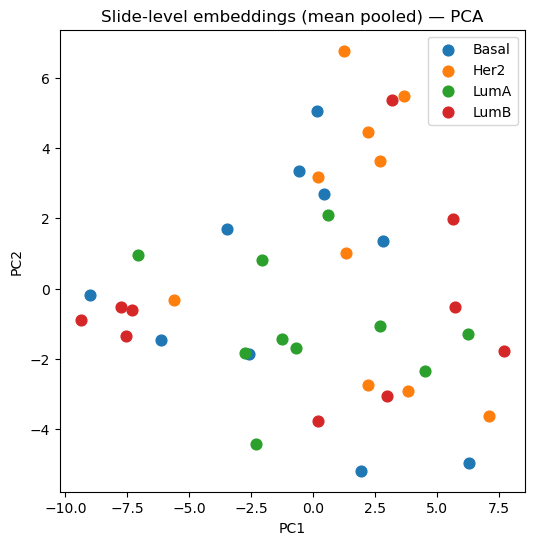

In [6]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2 = pca.fit_transform(X)

plt.figure(figsize=(6, 6))
for lab in sorted(set(y)):
    idx = (y == lab)
    plt.scatter(X2[idx, 0], X2[idx, 1], label=lab, s=60)

plt.title("Slide-level embeddings (mean pooled) — PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()


Quick quantitative sanity (optional): nearest-neighbor label consistency
Purpose

Check whether slides tend to be closer to same-label slides than random (very rough sanity metric).

In [7]:
from sklearn.metrics import pairwise_distances

D = pairwise_distances(X, metric="euclidean")
np.fill_diagonal(D, np.inf)

nn = D.argmin(axis=1)
nn_same = (y[nn] == y).mean()

print("Nearest-neighbor same-label rate:", nn_same)
print("Random baseline (approx):", (pd.Series(y).value_counts(normalize=True)**2).sum())


Nearest-neighbor same-label rate: 0.375
Random baseline (approx): 0.25


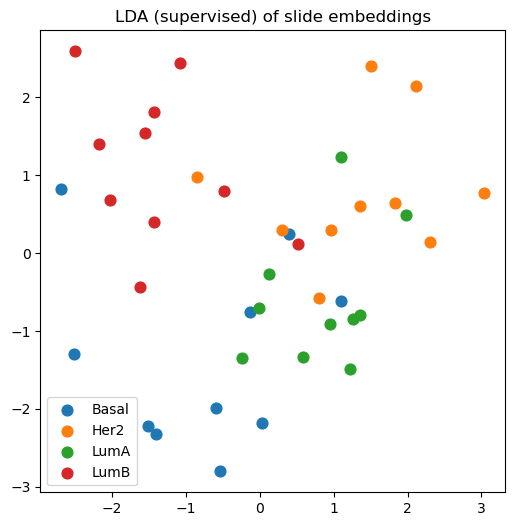

In [8]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)
X_lda = lda.fit_transform(X, y)

plt.figure(figsize=(6,6))
for lab in sorted(set(y)):
    idx = (y == lab)
    plt.scatter(X_lda[idx,0], X_lda[idx,1], label=lab, s=60)

plt.title("LDA (supervised) of slide embeddings")
plt.legend()
plt.show()


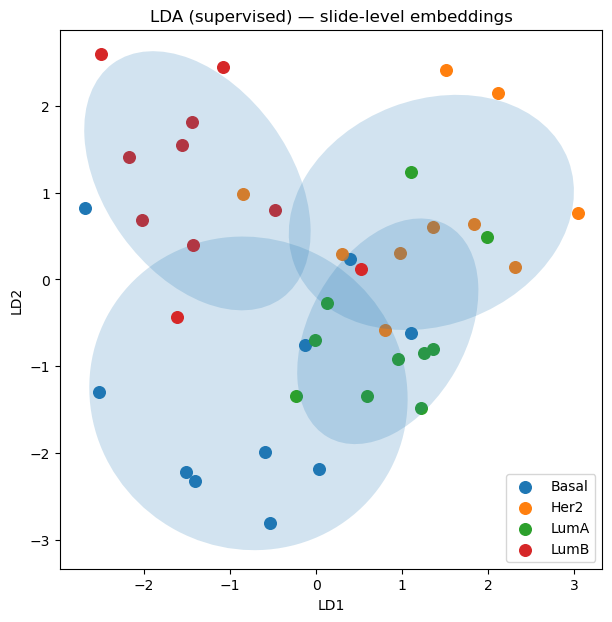

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_confidence_ellipse(x, y, ax, n_std=1.5, **kwargs):
    cov = np.cov(x, y)
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    width, height = 2 * n_std * np.sqrt(vals)
    ellipse = Ellipse(
        xy=(np.mean(x), np.mean(y)),
        width=width,
        height=height,
        angle=theta,
        **kwargs
    )
    ax.add_patch(ellipse)

plt.figure(figsize=(7,7))
ax = plt.gca()

for lab in sorted(set(y)):
    idx = (y == lab)
    ax.scatter(X_lda[idx,0], X_lda[idx,1], label=lab, s=70)
    plot_confidence_ellipse(
        X_lda[idx,0],
        X_lda[idx,1],
        ax,
        alpha=0.2
    )

plt.title("LDA (supervised) — slide-level embeddings")
plt.xlabel("LD1")
plt.ylabel("LD2")
plt.legend()
plt.show()


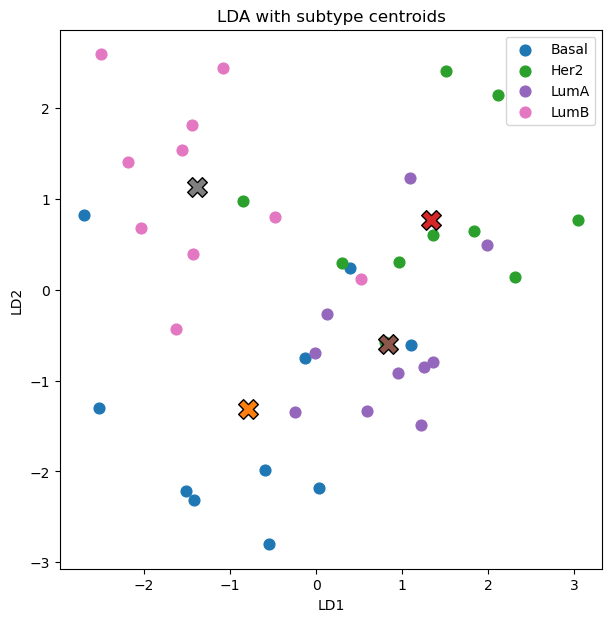

In [10]:
plt.figure(figsize=(7,7))

for lab in sorted(set(y)):
    idx = (y == lab)
    plt.scatter(X_lda[idx,0], X_lda[idx,1], label=lab, s=60)
    cx, cy = X_lda[idx].mean(axis=0)
    plt.scatter(cx, cy, marker="X", s=200, edgecolor="black")

plt.title("LDA with subtype centroids")
plt.xlabel("LD1")
plt.ylabel("LD2")
plt.legend()
plt.show()


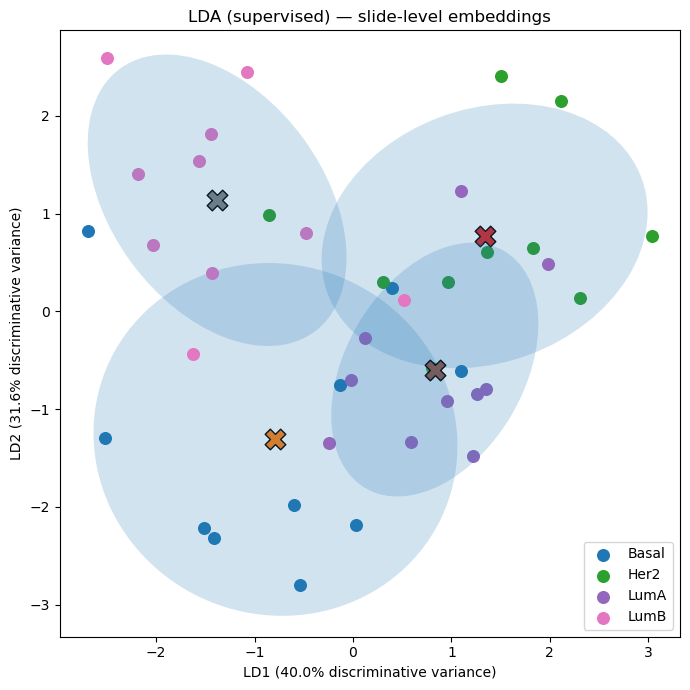

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Ellipse

# ---------- helper: confidence ellipse ----------
def confidence_ellipse(x, y, ax, n_std=1.5, alpha=0.2):
    if len(x) < 2:
        return

    cov = np.cov(x, y)
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]

    theta = np.degrees(np.arctan2(vecs[1, 0], vecs[0, 0]))
    width, height = 2 * n_std * np.sqrt(vals)

    ellipse = Ellipse(
        xy=(np.mean(x), np.mean(y)),
        width=width,
        height=height,
        angle=theta,
        alpha=alpha
    )
    ax.add_patch(ellipse)

# ---------- scale features ----------
X_scaled = StandardScaler().fit_transform(X)

# ---------- LDA ----------
lda = LDA(n_components=2)
X_lda = lda.fit_transform(X_scaled, y)
expl = lda.explained_variance_ratio_

# ---------- plot ----------
plt.figure(figsize=(7, 7))
ax = plt.gca()

for lab in sorted(set(y)):
    idx = (y == lab)

    ax.scatter(
        X_lda[idx, 0],
        X_lda[idx, 1],
        s=70,
        label=lab
    )

    # centroid
    cx, cy = X_lda[idx].mean(axis=0)
    ax.scatter(cx, cy, marker="X", s=220, edgecolor="black")

    # confidence ellipse
    confidence_ellipse(
        X_lda[idx, 0],
        X_lda[idx, 1],
        ax
    )

plt.title("LDA (supervised) — slide-level embeddings")
plt.xlabel(f"LD1 ({expl[0]*100:.1f}% discriminative variance)")
plt.ylabel(f"LD2 ({expl[1]*100:.1f}% discriminative variance)")
plt.legend()
plt.tight_layout()
plt.show()


5-fold CV accuracy: 0.4

Classification report:
               precision    recall  f1-score   support

       Basal       0.33      0.40      0.36        10
        Her2       0.44      0.40      0.42        10
        LumA       0.45      0.50      0.48        10
        LumB       0.38      0.30      0.33        10

    accuracy                           0.40        40
   macro avg       0.40      0.40      0.40        40
weighted avg       0.40      0.40      0.40        40



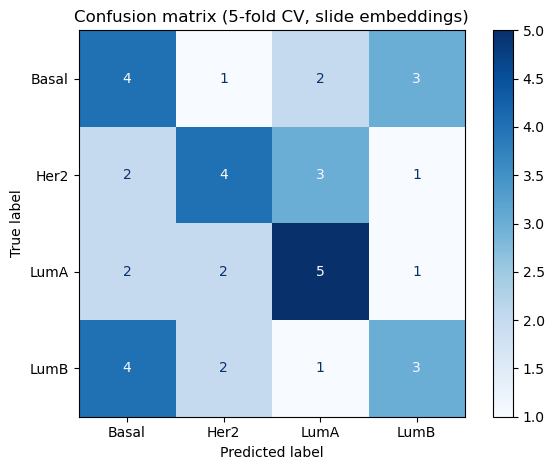

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

# Classifier (compatible with older sklearn)
clf = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=5000)
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Out-of-fold predictions
y_pred = cross_val_predict(clf, X, y, cv=cv)

# Metrics
acc = accuracy_score(y, y_pred)
print("5-fold CV accuracy:", round(acc, 3))
print("\nClassification report:\n", classification_report(y, y_pred))

# Confusion matrix
labels = sorted(set(y))
cm = confusion_matrix(y, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues")
plt.title("Confusion matrix (5-fold CV, slide embeddings)")
plt.tight_layout()
plt.show()


c:\Users\layan\miniconda3\envs\gdc\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


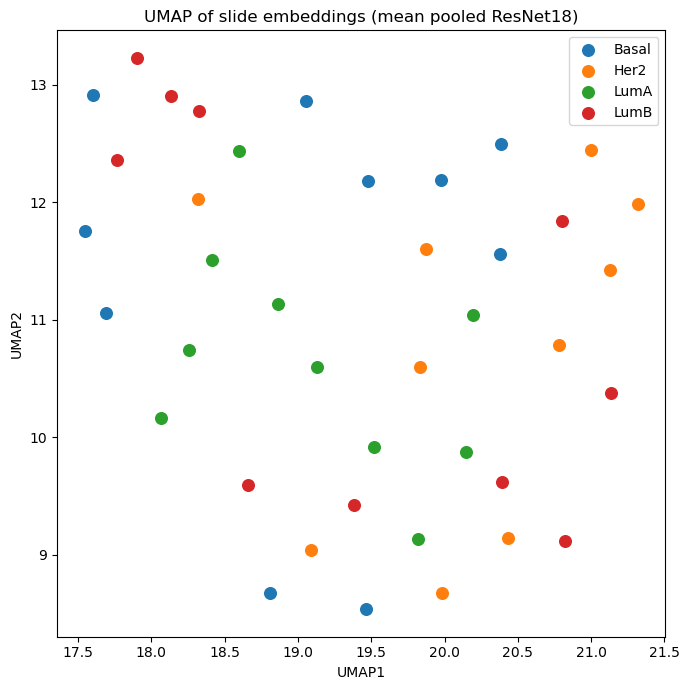

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# install once if needed:
# pip install umap-learn

import umap
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(X)

reducer = umap.UMAP(n_neighbors=10, min_dist=0.3, random_state=42)
X_umap = reducer.fit_transform(X_scaled)

plt.figure(figsize=(7,7))
for lab in sorted(set(y)):
    idx = (y == lab)
    plt.scatter(X_umap[idx,0], X_umap[idx,1], s=70, label=lab)

plt.title("UMAP of slide embeddings (mean pooled ResNet18)")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend()
plt.tight_layout()
plt.show()


c:\Users\layan\miniconda3\envs\gdc\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


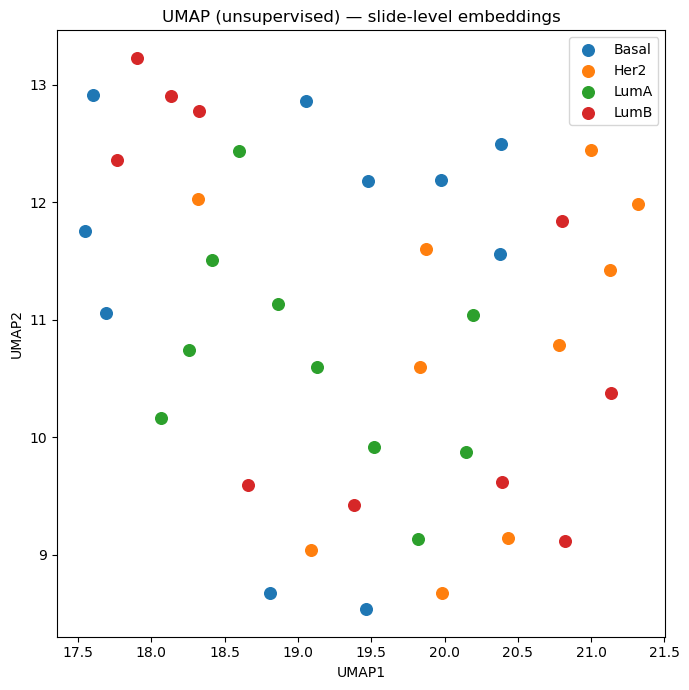

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import umap

X_scaled = StandardScaler().fit_transform(X)

reducer = umap.UMAP(
    n_neighbors=10,
    min_dist=0.3,
    random_state=42
)

X_umap = reducer.fit_transform(X_scaled)

plt.figure(figsize=(7,7))
for lab in sorted(set(y)):
    idx = (y == lab)
    plt.scatter(X_umap[idx,0], X_umap[idx,1], s=70, label=lab)

plt.title("UMAP (unsupervised) — slide-level embeddings")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend()
plt.tight_layout()
plt.show()


Basal vs Non-Basal (5-fold CV)
  Accuracy         : 0.75
  Balanced Accuracy: 0.633
  ROC AUC          : 0.61


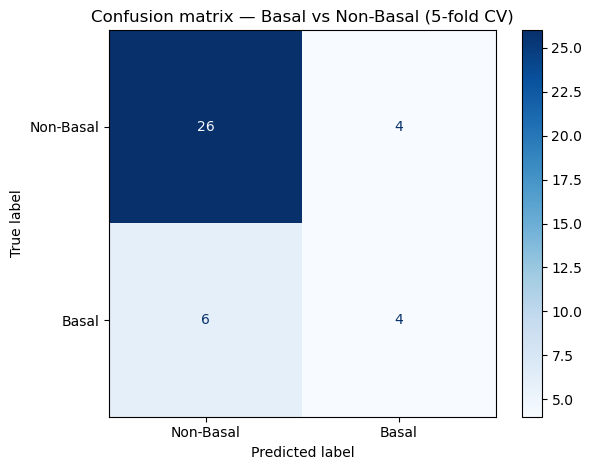

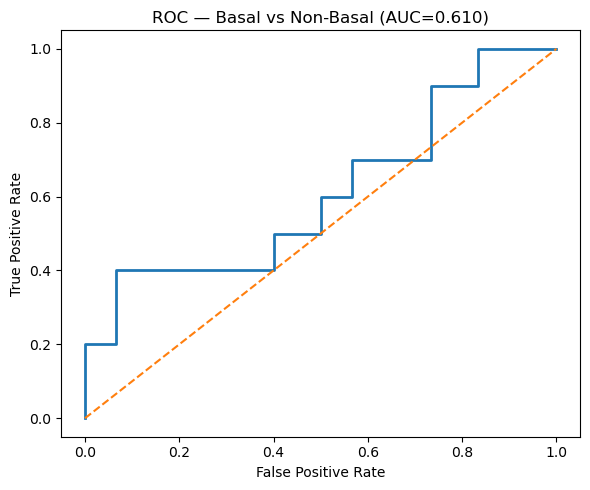

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score,
    confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, roc_curve
)

# Binary label: Basal vs Non-Basal
y_bin = (y == "Basal").astype(int)  # 1=Basal, 0=Non-Basal

clf = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=5000)
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Out-of-fold predictions
proba = cross_val_predict(clf, X, y_bin, cv=cv, method="predict_proba")[:, 1]
pred  = (proba >= 0.5).astype(int)

acc  = accuracy_score(y_bin, pred)
bacc = balanced_accuracy_score(y_bin, pred)
auc  = roc_auc_score(y_bin, proba)

print("Basal vs Non-Basal (5-fold CV)")
print("  Accuracy         :", round(acc, 3))
print("  Balanced Accuracy:", round(bacc, 3))
print("  ROC AUC          :", round(auc, 3))

# Confusion matrix
cm = confusion_matrix(y_bin, pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Non-Basal", "Basal"])
disp.plot(cmap="Blues")
plt.title("Confusion matrix — Basal vs Non-Basal (5-fold CV)")
plt.tight_layout()
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_bin, proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], linestyle="--")
plt.title(f"ROC — Basal vs Non-Basal (AUC={auc:.3f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.tight_layout()
plt.show()


Luminal (A+B) vs Non-Luminal (5-fold CV)
  Accuracy         : 0.6
  Balanced Accuracy: 0.6
  ROC AUC          : 0.657


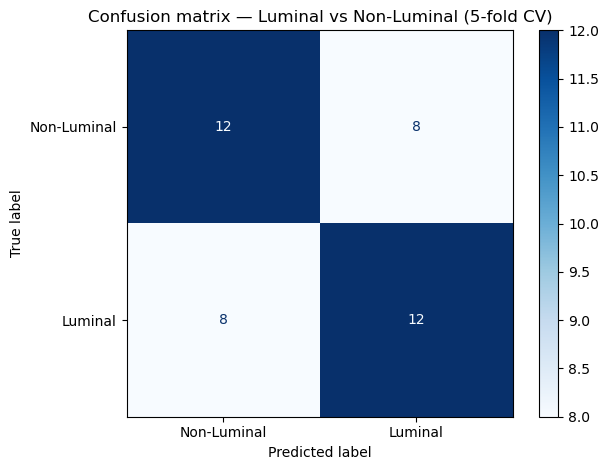

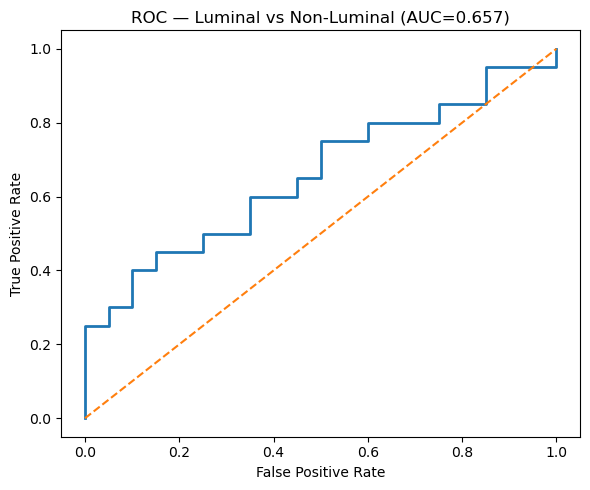

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score,
    confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, roc_curve
)

# Binary label: Luminal (LumA or LumB) vs Non-Luminal (Basal or Her2)
y_bin = np.isin(y, ["LumA", "LumB"]).astype(int)  # 1=Luminal, 0=Non-Luminal

clf = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=5000)
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

proba = cross_val_predict(clf, X, y_bin, cv=cv, method="predict_proba")[:, 1]
pred  = (proba >= 0.5).astype(int)

acc  = accuracy_score(y_bin, pred)
bacc = balanced_accuracy_score(y_bin, pred)
auc  = roc_auc_score(y_bin, proba)

print("Luminal (A+B) vs Non-Luminal (5-fold CV)")
print("  Accuracy         :", round(acc, 3))
print("  Balanced Accuracy:", round(bacc, 3))
print("  ROC AUC          :", round(auc, 3))

cm = confusion_matrix(y_bin, pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Non-Luminal", "Luminal"])
disp.plot(cmap="Blues")
plt.title("Confusion matrix — Luminal vs Non-Luminal (5-fold CV)")
plt.tight_layout()
plt.show()

fpr, tpr, _ = roc_curve(y_bin, proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], linestyle="--")
plt.title(f"ROC — Luminal vs Non-Luminal (AUC={auc:.3f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.tight_layout()
plt.show()


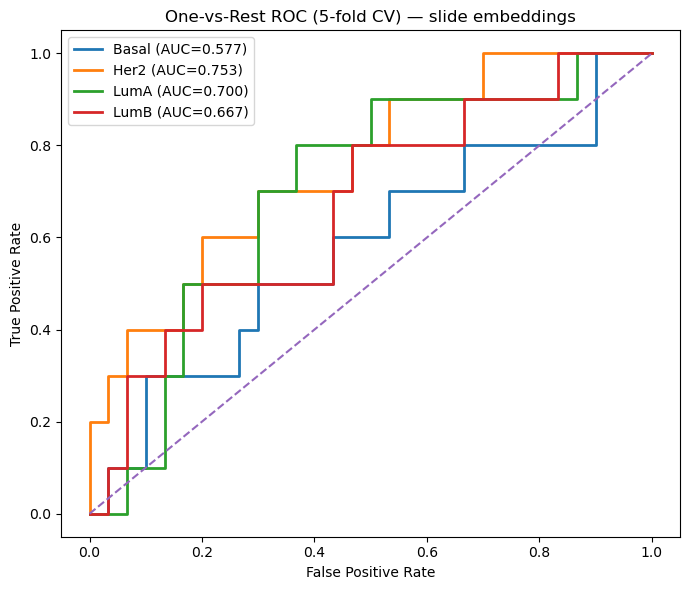

One-vs-Rest AUCs: {np.str_('Basal'): 0.577, np.str_('Her2'): 0.753, np.str_('LumA'): 0.7, np.str_('LumB'): 0.667}


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_auc_score, roc_curve

classes = sorted(list(set(y)))
Y = label_binarize(y, classes=classes)  # shape: (n_samples, n_classes)

clf = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=5000)
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Out-of-fold probabilities for multiclass
proba = cross_val_predict(clf, X, y, cv=cv, method="predict_proba")  # (n, K)

plt.figure(figsize=(7,6))
aucs = {}

for i, lab in enumerate(classes):
    auc = roc_auc_score(Y[:, i], proba[:, i])
    aucs[lab] = auc
    fpr, tpr, _ = roc_curve(Y[:, i], proba[:, i])
    plt.plot(fpr, tpr, linewidth=2, label=f"{lab} (AUC={auc:.3f})")

plt.plot([0,1], [0,1], linestyle="--")
plt.title("One-vs-Rest ROC (5-fold CV) — slide embeddings")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()

print("One-vs-Rest AUCs:", {k: round(v, 3) for k, v in aucs.items()})


Basal vs Non-Basal (5-fold CV)
  ROC AUC: 0.61
  Best threshold (Youden J): 0.784
  TPR at best thr: 0.4
  FPR at best thr: 0.067


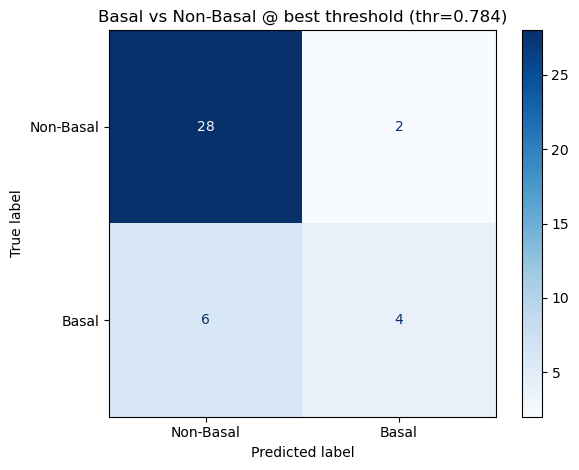

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

y_bin = (y == "Basal").astype(int)

clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=5000))
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

proba = cross_val_predict(clf, X, y_bin, cv=cv, method="predict_proba")[:, 1]
auc = roc_auc_score(y_bin, proba)

fpr, tpr, thr = roc_curve(y_bin, proba)
j = tpr - fpr
best_i = np.argmax(j)
best_thr = thr[best_i]

pred = (proba >= best_thr).astype(int)

print("Basal vs Non-Basal (5-fold CV)")
print("  ROC AUC:", round(auc, 3))
print("  Best threshold (Youden J):", round(float(best_thr), 3))
print("  TPR at best thr:", round(float(tpr[best_i]), 3))
print("  FPR at best thr:", round(float(fpr[best_i]), 3))

cm = confusion_matrix(y_bin, pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Non-Basal", "Basal"])
disp.plot(cmap="Blues")
plt.title(f"Basal vs Non-Basal @ best threshold (thr={best_thr:.3f})")
plt.tight_layout()
plt.show()


In [23]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import balanced_accuracy_score, f1_score, classification_report

clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=5000))
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

y_pred = cross_val_predict(clf, X, y, cv=cv)

bacc = balanced_accuracy_score(y, y_pred)
mf1  = f1_score(y, y_pred, average="macro")

print("Multiclass (4-way) — 5-fold CV on slide embeddings")
print("  Balanced accuracy:", round(bacc, 3))
print("  Macro-F1         :", round(mf1, 3))
print("\nReport:\n", classification_report(y, y_pred))


Multiclass (4-way) — 5-fold CV on slide embeddings
  Balanced accuracy: 0.4
  Macro-F1         : 0.399

Report:
               precision    recall  f1-score   support

       Basal       0.33      0.40      0.36        10
        Her2       0.44      0.40      0.42        10
        LumA       0.45      0.50      0.48        10
        LumB       0.38      0.30      0.33        10

    accuracy                           0.40        40
   macro avg       0.40      0.40      0.40        40
weighted avg       0.40      0.40      0.40        40



In [24]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_auc_score

classes = sorted(list(set(y)))
Y = label_binarize(y, classes=classes)

clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=5000))
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

proba = cross_val_predict(clf, X, y, cv=cv, method="predict_proba")

aucs = {}
for i, lab in enumerate(classes):
    aucs[lab] = roc_auc_score(Y[:, i], proba[:, i])

print("One-vs-Rest AUC leaderboard (5-fold CV):")
for lab, auc in sorted(aucs.items(), key=lambda kv: kv[1], reverse=True):
    print(f"  {lab:5s}  AUC = {auc:.3f}")


One-vs-Rest AUC leaderboard (5-fold CV):
  Her2   AUC = 0.753
  LumA   AUC = 0.700
  LumB   AUC = 0.667
  Basal  AUC = 0.577
